In [1]:
# Use for pass and carries datasets, files with 2 heatmaps (start-end)

import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import json
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from itertools import product
import matplotlib.pyplot as plt
import time
import random
from math import ceil

class HeatmapCSVLoader(Dataset):
    def __init__(self, csv_path):
        self.data = pd.read_csv(csv_path)
        self.heatmaps_start = self.data["passes-start-heatmap"]
        self.heatmaps_end = self.data["passes-end-heatmap"]
        self.ids = self.data["heatmapsId"]
        self.playerIds = self.data["playerId"]
        self.teamIds = self.data["teamId"]
        self.seasons = self.data["season"]
    
    def __len__(self):
        # Return the number of rows in the dataset
        return len(self.data)
    
    def __getitem__(self, idx):
        # Parse heatmaps JSON string
        heatmap_start = json.loads(self.heatmaps_start.iloc[idx])
        heatmap_start_tensor = torch.tensor(heatmap_start, dtype=torch.float32)  # Convert to tensor
        heatmap_end = json.loads(self.heatmaps_end.iloc[idx])
        heatmap_end_tensor = torch.tensor(heatmap_end, dtype=torch.float32)  # Convert to tensor
        
        # Add channel dimension for PyTorch (batch, channel, height, width)
        heatmap_start_tensor = heatmap_start_tensor.unsqueeze(0)
        heatmap_end_tensor = heatmap_end_tensor.unsqueeze(0)
        
        # Return heatmap tensor and its metadata
        return (
            heatmap_start_tensor,
            heatmap_end_tensor,
            self.ids.iloc[idx],
            self.playerIds.iloc[idx],
            self.teamIds.iloc[idx],
            self.seasons.iloc[idx]
        )

In [2]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.4.1+cu121
CUDA available: True


In [3]:
# for passes and carries
# Filter test set to use only players with multiple heatmaps in a team/season for the retrieval task
from collections import defaultdict

# Load test dataset
test_data = pd.read_csv('/kaggle/input/pass-dataset/pass-test.csv')

# Group by playerId, teamId, and season and count rows in each group
grouped = test_data.groupby(["playerId", "teamId", "season"]).size()

# Filter combinations with more than one heatmap
valid_combinations = grouped[grouped > 1].index  # Get the indices of valid groups

# Create filtered test instances
filtered_test_instances = defaultdict(list)
for _, row in test_data.iterrows():
    key = (row["playerId"], row["teamId"], row["season"])
    if key in valid_combinations:
        # Add heatmap and heatmapsId to corresponding key
        heatmap_start = json.loads(row["passes-start-heatmap"])
        heatmap_end = json.loads(row["passes-end-heatmap"])
        heatmaps_id = row["heatmapsId"]
        filtered_test_instances[key].append((heatmaps_id, heatmap_start, heatmap_end))

# Convert to a list of tuples for later use
filtered_test_instances = [
    (playerId, teamId, season, heatmaps)
    for (playerId, teamId, season), heatmaps in filtered_test_instances.items()
]

In [4]:
len(filtered_test_instances)

2148

In [5]:
# Encoder class for grid search

class Encoder(nn.Module):
    def __init__(self, input_channels, bottleneck_size, dropout_rate):
        super(Encoder, self).__init__()
        
        # Conv Block 1
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(p=dropout_rate)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        # Conv Block 2
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, groups=64),
            nn.Conv2d(128, 128, kernel_size=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, groups=128),
            nn.Conv2d(128, 128, kernel_size=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(p=dropout_rate)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        # Conv Block 3
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(p=dropout_rate)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        # Compute flattened size after convolutions and pooling
        self.flattened_size = 256 * 4 * 2  # Computed from input size [1, 35, 23]
        self.flatten = nn.Flatten()
        self.dense = nn.Sequential(
            nn.Linear(self.flattened_size, bottleneck_size),
            nn.Dropout(p=dropout_rate)
        )
    
    def forward(self, x):
        # Conv Block 1
        x = self.conv_block1(x)
        x, indices1 = self.pool1(x)
        
        # Conv Block 2
        x = self.conv_block2(x)
        x, indices2 = self.pool2(x)
        
        # Conv Block 3
        x = self.conv_block3(x)
        x, indices3 = self.pool3(x)

        # Flatten and bottleneck
        x = self.flatten(x)
        bottleneck = self.dense(x)
        
        return bottleneck, [indices1, indices2, indices3]

In [6]:
# Decoder class for grid search

class Decoder(nn.Module):
    def __init__(self, input_channels, bottleneck_size, dropout_rate):
        super(Decoder, self).__init__()

        self.dense = nn.Sequential(
            nn.Linear(bottleneck_size, 256 * 4 * 2),
            nn.ReLU()
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(256, 4, 2))

        self.unpool3 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.deconv_block3 = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.unpool2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.deconv_block2 = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.unpool1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.deconv_block1 = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, input_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(input_channels),
            nn.Sigmoid()
        )

    def forward(self, x, indices_list, output_sizes):
        # Dense layer and unflatten
        x = self.dense(x)
        x = self.unflatten(x)

        # Unpooling and deconvolution
        x = self.unpool3(x, indices_list[2], output_size=output_sizes[2])
        x = self.deconv_block3(x)

        x = self.unpool2(x, indices_list[1], output_size=output_sizes[1])
        x = self.deconv_block2(x)

        x = self.unpool1(x, indices_list[0], output_size=output_sizes[0])
        x = self.deconv_block1(x)

        return x

In [7]:
# Autoencoder class for grid search

class Autoencoder(nn.Module):
    def __init__(self, input_channels, bottleneck_size, dropout_rate):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_channels, bottleneck_size, dropout_rate)
        self.decoder = Decoder(input_channels, bottleneck_size, dropout_rate)

    def forward(self, x):
        # Encoder
        bottleneck, indices_list = self.encoder(x)

        # Verify output_sizes match shapes before pooling
        output_sizes = [
            torch.Size([x.size(0), 1, 35, 23]),    # Before Pool1
            torch.Size([x.size(0), 64, 17, 11]),  # Before Pool2
            torch.Size([x.size(0), 128, 8, 5])    # Before Pool3
        ]

        # Decoder
        reconstructed = self.decoder(bottleneck, indices_list, output_sizes)
        return reconstructed

In [8]:
# Define EarlyStopping class

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [9]:
# Function to get optimizer

def get_optimizer(optimizer_name, model_params, lr, weight_decay):
    if optimizer_name == 'Adam':
        return optim.Adam(model_params, lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'AdamW':
        return optim.AdamW(model_params, lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'SGD':
        return optim.SGD(model_params, lr=lr, momentum=0.9, weight_decay=weight_decay)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

In [10]:
# Function to get loss function

def get_loss_function(loss_name):
    if loss_name == 'MSELoss':
        return nn.MSELoss()
    elif loss_name == 'SmoothL1Loss':
        return nn.SmoothL1Loss()
    else:
        raise ValueError(f"Unknown loss function: {loss_name}")

In [11]:
results = []

# Function to add a result
def save_result(hyperparams, metrics):
    result = {
        "hyperparameters": hyperparams,
        "metrics": metrics,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
    }
    results.append(result)

In [12]:
# For passes and carries
# Create GPU-based latent_vectors_torch embeddings for similarity computation

def create_test_embeddings(embedder,filtered_test_instances):
    latent_vectors_torch = {}
    for playerId, teamId, season, heatmaps in filtered_test_instances:
        vectors_with_ids = []
        for heatmaps_id, heatmap_start, heatmap_end in heatmaps:
            # Convert heatmap to a PyTorch tensor and move it to the GPU
            hm_start_tensor = torch.tensor(heatmap_start, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
            hm_end_tensor = torch.tensor(heatmap_end, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
            hm_tensor = torch.cat((hm_start_tensor,hm_end_tensor),dim=1)
            bottleneck, _ = embedder(hm_tensor)  # Get the bottleneck representation
            # Store the tensor directly without detaching or moving it to CPU
            vectors_with_ids.append((heatmaps_id, bottleneck))
        latent_vectors_torch[(playerId, teamId, season)] = vectors_with_ids
    
    num_keys = len(latent_vectors_torch)
    print(f"Number of unique (playerId, teamId, season) combinations: {num_keys}")
    total_latent_vectors_torch = sum(len(vectors) for vectors in latent_vectors_torch.values())
    print(f"Total number of latent vectors: {total_latent_vectors_torch}")
    return latent_vectors_torch

In [13]:
# Function to compute cosine similarity (GPU/CPU)

from sklearn.metrics.pairwise import cosine_similarity

def compute_similarity(latent_vectors, k_values, use_gpu):
    """
    Computes MRR and Top-k accuracy metrics for a set of latent vectors.

    Parameters:
        latent_vectors (dict): Dictionary of latent vectors.
        k_values (list): List of k values for top-k accuracy.
        use_gpu (bool): Whether to use GPU for computations.

    Returns:
        avg_mrr (float): Average MRR.
        avg_top_k_values (dict): Average Top-k accuracy for each k.
    """
    results = []

    for (playerId, teamId, season), vectors_with_ids in latent_vectors.items():
        for i, (heatmaps_id, query_vector) in enumerate(vectors_with_ids):
            similarities = []

            for (other_playerId, other_teamId, other_season), other_vectors_with_ids in latent_vectors.items():
                for other_heatmaps_id, other_vector in other_vectors_with_ids:
                    if other_heatmaps_id == heatmaps_id:
                        continue

                    if use_gpu:
                        query_tensor = torch.tensor(query_vector, dtype=torch.float32).flatten().unsqueeze(0).cuda()
                        other_tensor = torch.tensor(other_vector, dtype=torch.float32).flatten().unsqueeze(0).cuda()
                        sim = torch.nn.functional.cosine_similarity(query_tensor, other_tensor).item()
                    else:
                        sim = cosine_similarity(query_vector.reshape(1, -1), other_vector.reshape(1, -1))[0][0]

                    similarities.append((sim, (other_playerId, other_teamId, other_season)))

            similarities.sort(reverse=True, key=lambda x: x[0])
            ranks = {k: [key == (playerId, teamId, season) for _, key in similarities[:k]] for k in k_values}
            top_k_values = {k: 1 if any(ranks[k]) else 0 for k in k_values}
            mrr = 1 / (ranks[10].index(True) + 1) if any(ranks[10]) else 0

            results.append({
                'query': (playerId, teamId, season),
                'mrr': mrr,
                'top_k_values': top_k_values,
            })

    avg_mrr = np.mean([result['mrr'] for result in results])
    avg_top_k_values = {k: np.mean([result['top_k_values'][k] for result in results]) for k in k_values}

    return avg_mrr, avg_top_k_values

In [15]:
# Utility function to create a test subset
def create_test_subset(test_instances, size_fraction=0.10):
    subset_size = ceil(len(test_instances) * size_fraction)
    subset_indices = random.sample(range(len(test_instances)), subset_size)
    return [test_instances[i] for i in subset_indices]

In [14]:
# Function to compute and store metrics
def compute_and_store_metrics(autoencoder, test_subset, epoch, k_values, use_gpu, history):
    print(f"Creating embeddings at epoch {epoch} on a subset of size {len(test_subset)}...")
    latent_vectors_torch = create_test_embeddings(autoencoder.encoder, test_subset)

    print(f"Computing metrics at epoch {epoch}...")
    metrics_start_time = time.time()
    avg_mrr, avg_top_k_values = compute_similarity(latent_vectors_torch, k_values, use_gpu) # computing similarity with cosine similarity
    metrics_end_time = time.time()

    print(f"Metrics computation time (epoch {epoch}): {metrics_end_time - metrics_start_time:.2f} seconds")
    history["mrr"].append(avg_mrr)
    print(f"Average MRR: {avg_mrr:.4f}")
    
    for k, avg_top_k in avg_top_k_values.items():
        history["top_k_accuracies"][k].append(avg_top_k)
        print(f"Average Top-{k} Accuracy: {avg_top_k:.4f}")

In [31]:
train_set = HeatmapCSVLoader(csv_path="/kaggle/input/pass-dataset/pass-train.csv")
val_set = HeatmapCSVLoader(csv_path="/kaggle/input/pass-dataset/pass-validation.csv")

In [18]:
# Hyperparameter grid

learning_rates = [1e-4]
bottleneck_sizes = [32]
optimizers = ['Adam']
loss_functions = ['MSELoss']
batch_sizes = [128]
weight_decays = [0]
dropout_rates = [0.2]

In [34]:
# Final passing, carrying and ball recovery+tackling models
# Using train/validation split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
k_values = [1, 3, 5, 10]  # List of k values
use_gpu = True

results = []
num_epochs = 25

start_time = time.time()
# Grid Search Loop
for lr, bottleneck, optimizer_name, loss_name, batch_size, weight_decay, dropout_rate in product(
    learning_rates, bottleneck_sizes, optimizers, loss_functions, batch_sizes, weight_decays, dropout_rates
):
    # Prepare DataLoader
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size)
    
    # Initialize model
    autoencoder = Autoencoder(input_channels=2, bottleneck_size=bottleneck, dropout_rate=dropout_rate).to(device)
    
    # Get optimizer and loss function
    optimizer = get_optimizer(optimizer_name, autoencoder.parameters(), lr, weight_decay)
    criterion = get_loss_function(loss_name)

    # Record hyperparameters
    hyperparams = {
        "learning_rate": lr, "bottleneck_size": bottleneck, "optimizer": optimizer_name,
        "loss_function": loss_name, "batch_size": batch_size, "weight_decay": weight_decay,
        "dropout_rate": dropout_rate
    }

    # History tracking
    history = {
        "train_loss": [], "val_loss": [], "learning_rate": [], "mrr": [],
        "top_k_accuracies": {k: [] for k in k_values}
    }

    # Train model
    early_stopping = EarlyStopping(patience=5)
    print(f"Training model with parameters: \nLearning Rate: {lr}, Bottleneck: {bottleneck}, Optimizer: {optimizer_name}, Loss Function: {loss_name},\n Batch Size: {batch_size}, Weight Decay: {weight_decay}, Dropout Rate: {dropout_rate}")
    for epoch in range(num_epochs):
        autoencoder.train()
        train_loss = 0
        for batch in train_loader:
            images_start, images_end, ids, playerIds, teamIds, seasons = batch  # Unpack images and metadata
            images_start = images_start.to(device)
            images_end = images_end.to(device)

            #forward pass 
            input_tensor = torch.cat((images_start, images_end), dim=1)
            reconstructed = autoencoder(input_tensor)
            loss = criterion(reconstructed, input_tensor)  
        
            #backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        history["train_loss"].append(train_loss)

        # Validate model
        autoencoder.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                images_start, images_end, ids, playerIds, teamIds, seasons = batch # Unpack images and metadata
                images_start = images_start.to(device)
                images_end = images_end.to(device)
                input_tensor = torch.cat((images_start, images_end), dim=1)
                reconstructed = autoencoder(input_tensor)
                val_loss += criterion(reconstructed, input_tensor).item() 
        val_loss /= len(val_loader)
        history["val_loss"].append(val_loss)
        
        # Check early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            break

        print(f"Epoch [{epoch+1}/{num_epochs}], Average Batch Training Loss: {train_loss}, Average Batch Validation Loss: {val_loss}")

    test_subset = create_test_subset(filtered_test_instances)
    compute_and_store_metrics(autoencoder, test_subset, epoch + 1, k_values, use_gpu, history)
    
    results.append({"hyperparams": hyperparams, "history_metrics": history}) #metrics
    with open("pass-model-results.json", "w") as f:
        json.dump(results, f, indent=4)
        print("pass-model-results.json updated")

# Save model
torch.save(autoencoder, "pass-model.pth")
    
end_time = time.time()
print(f"Execution time: {end_time - start_time:.2f} seconds")

Training model with parameters: 
Learning Rate: 0.0001, Bottleneck: 32, Optimizer: Adam, Loss Function: MSELoss,
 Batch Size: 128, Weight Decay: 0, Dropout Rate: 0.2
Epoch [1/25], Average Batch Training Loss: 0.03550460984220179, Average Batch Validation Loss: 0.026847146187598505
Epoch [2/25], Average Batch Training Loss: 0.023848173501108474, Average Batch Validation Loss: 0.020849779473307233
Epoch [3/25], Average Batch Training Loss: 0.018920157801547495, Average Batch Validation Loss: 0.01668382006464526
Epoch [4/25], Average Batch Training Loss: 0.015073702545564095, Average Batch Validation Loss: 0.013198036067963888
Epoch [5/25], Average Batch Training Loss: 0.012027648628222571, Average Batch Validation Loss: 0.010245694677966337
Epoch [6/25], Average Batch Training Loss: 0.009605874210301277, Average Batch Validation Loss: 0.007670042850077152
Epoch [7/25], Average Batch Training Loss: 0.007760559222091445, Average Batch Validation Loss: 0.006054977009383341
Epoch [8/25], Ave

<ipython-input-13-4bc8d80f1a81>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_tensor = torch.tensor(query_vector, dtype=torch.float32).flatten().unsqueeze(0).cuda()
<ipython-input-13-4bc8d80f1a81>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  other_tensor = torch.tensor(other_vector, dtype=torch.float32).flatten().unsqueeze(0).cuda()


Metrics computation time (epoch 25): 34.52 seconds
Average MRR: 0.2570
Average Top-1 Accuracy: 0.1729
Average Top-3 Accuracy: 0.2910
Average Top-5 Accuracy: 0.3764
Average Top-10 Accuracy: 0.4792
pass-model-results.json updated
Execution time: 3117.43 seconds


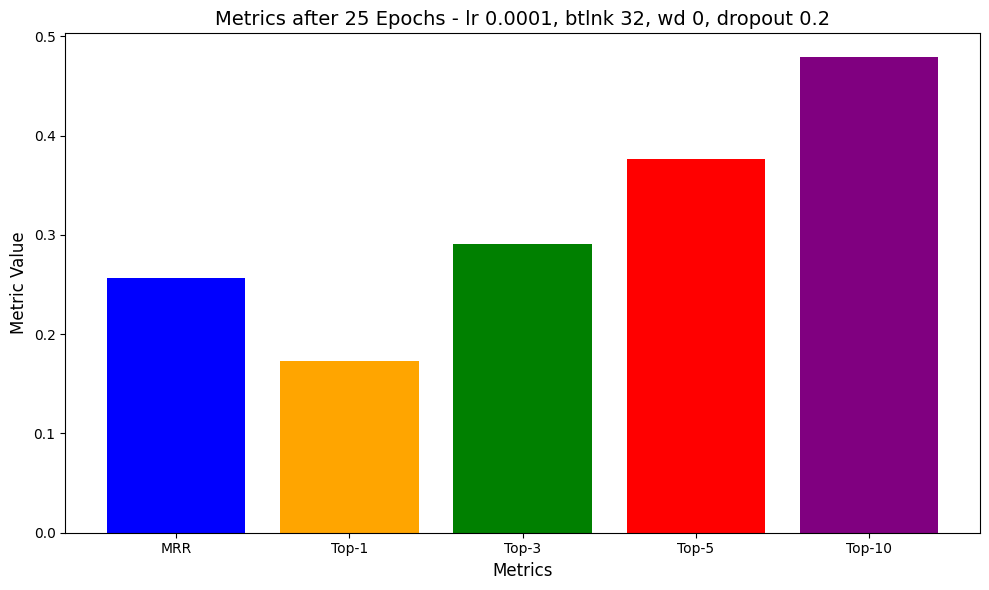

In [35]:
# Get metrics bar chart
import matplotlib.pyplot as plt

# Load the results from JSON
with open("pass-model-results.json", "r") as f:
    results = json.load(f)

# Extract metrics and hyperparameters (assuming only one model in results)
model_result = results[0]
hyperparams = model_result["hyperparams"]
history_metrics = model_result["history_metrics"]

# Extract MRR and Top-k accuracies from the final epoch
final_epoch_mrr = history_metrics["mrr"][-1]
top_k_accuracies = {f"Top-{k}": history_metrics["top_k_accuracies"][str(k)][-1] for k in [1, 3, 5, 10]}

# Prepare data for the bar chart
metrics = {"MRR": final_epoch_mrr}
metrics.update(top_k_accuracies)
metric_names = list(metrics.keys())
metric_values = list(metrics.values())

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(metric_names, metric_values, color=["blue", "orange", "green", "red", "purple"])

# Set chart title and labels
title = (
    f"Metrics after 25 Epochs - "
    f"lr {hyperparams['learning_rate']}, btlnk {hyperparams['bottleneck_size']}, "
    f"wd {hyperparams['weight_decay']}, dropout {hyperparams['dropout_rate']}"
)
plt.title(title, fontsize=14)
plt.ylabel("Metric Value", fontsize=12)
plt.xlabel("Metrics", fontsize=12)

# Display the bar chart
plt.tight_layout()
plt.show()

In [36]:
# load test set
test_set = HeatmapCSVLoader(csv_path="/kaggle/input/pass-dataset/pass-test.csv")
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

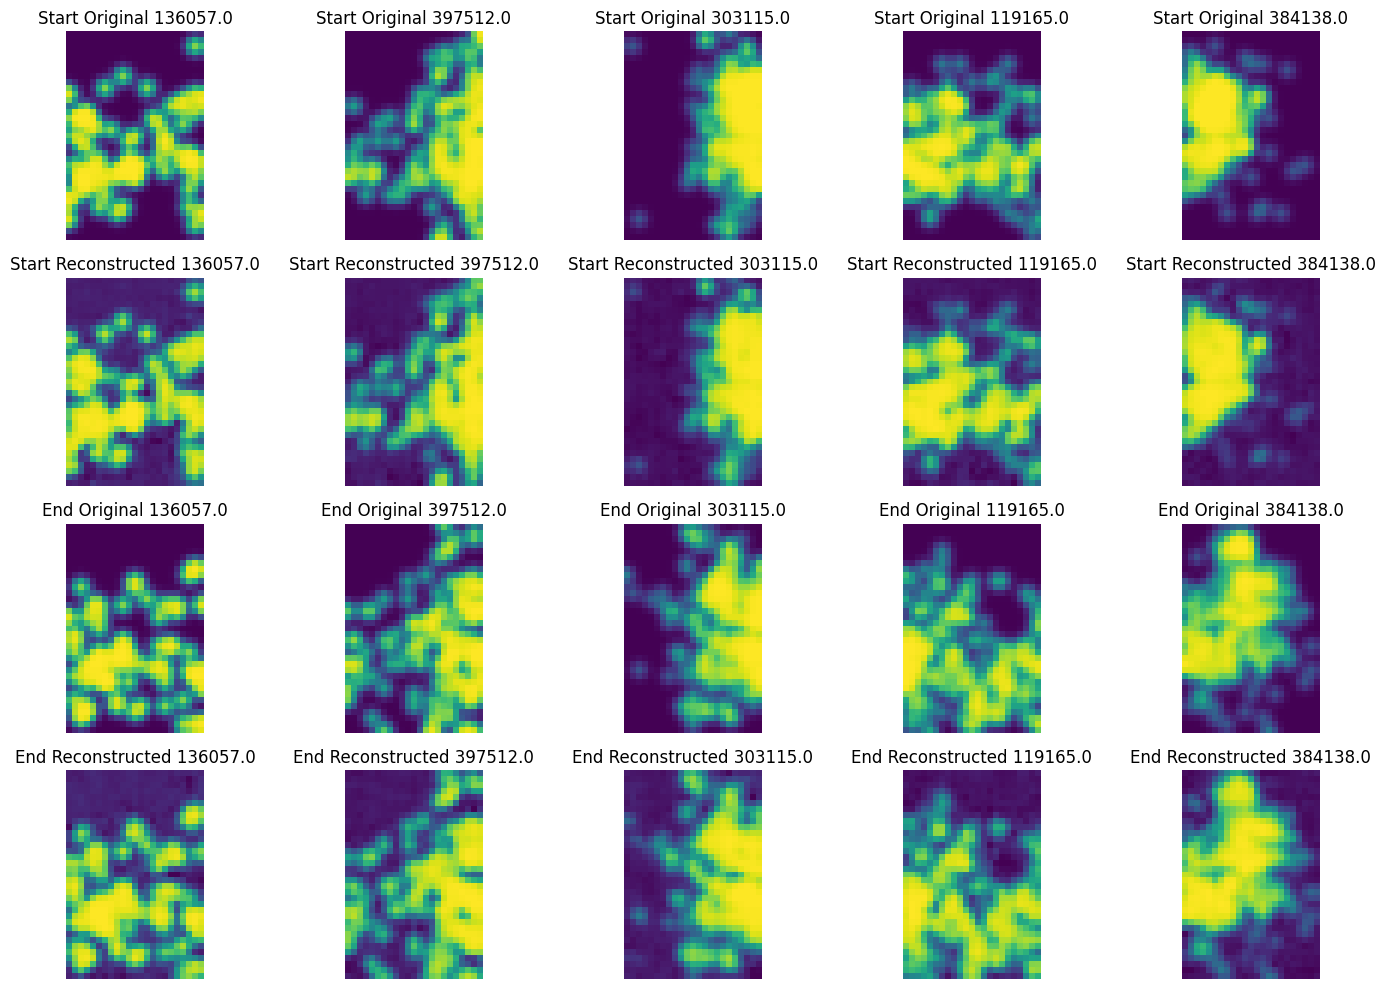

In [37]:
# Check reconstruction ability of autoencoder

# Set the autoencoder to evaluation mode
autoencoder.eval()

# Get a batch of test images
images_start, images_end, ids, playerIds, teamIds, seasons = next(iter(test_loader))

# Move images to the selected device
images_start = images_start.to(device)
images_end = images_end.to(device)

# Reconstruct images using the autoencoder
with torch.no_grad():
    input_tensor = torch.cat((images_start, images_end), dim=1)
    reconstructed = autoencoder(input_tensor)

# Define the number of examples to visualize
num_examples = min(len(input_tensor), 5)

# Plot in the desired order: Start original - Start reconstructed - End original - End reconstructed
fig, axes = plt.subplots(4, num_examples, figsize=(15, 10))  # 4 rows for start/reconstructed/end/reconstructed

for i in range(num_examples):
    # Start Original
    axes[0, i].imshow(input_tensor[i, 0].cpu().numpy(), cmap='viridis')
    axes[0, i].set_title(f"Start Original {playerIds[i]}" if isinstance(ids, (list, tuple)) else "Start Original")
    axes[0, i].axis('off')

    # Start Reconstructed
    axes[1, i].imshow(reconstructed[i, 0].cpu().numpy(), cmap='viridis')
    axes[1, i].set_title(f"Start Reconstructed {playerIds[i]}" if isinstance(ids, (list, tuple)) else "Start Reconstructed")
    axes[1, i].axis('off')

    # End Original
    axes[2, i].imshow(input_tensor[i, 1].cpu().numpy(), cmap='viridis')
    axes[2, i].set_title(f"End Original {playerIds[i]}" if isinstance(ids, (list, tuple)) else "End Original")
    axes[2, i].axis('off')

    # End Reconstructed
    axes[3, i].imshow(reconstructed[i, 1].cpu().numpy(), cmap='viridis')
    axes[3, i].set_title(f"End Reconstructed {playerIds[i]}" if isinstance(ids, (list, tuple)) else "End Reconstructed")
    axes[3, i].axis('off')

plt.tight_layout()
plt.savefig("comparison_original_vs_reconstructed_channels.png", dpi=300, bbox_inches="tight")
plt.show()

In [38]:
def create_embeddings(embedder, dataset):
    """
    Create embeddings for each heatmap in the dataset without aggregation.

    Args:
        embedder: The encoder part of the trained autoencoder.
        dataset: A PyTorch Dataset containing heatmaps and metadata.

    Returns:
        embeddings: A list of dictionaries with embedding and metadata.
    """
    embedder.eval()  # Set embedder to evaluation mode
    embeddings = []  # Store all embeddings with metadata

    for i in range(len(dataset)):
        # Load a single sample
        heatmap_start, heatmap_end, heatmaps_id, playerId, teamId, season = dataset[i]

        # Prepare input tensor
        heatmap_start = heatmap_start.unsqueeze(0).to(device)  # Add batch dimension and move to device
        heatmap_end = heatmap_end.unsqueeze(0).to(device)      # Add batch dimension and move to device
        input_tensor = torch.cat((heatmap_start, heatmap_end), dim=1)  # Concatenate along the channel dimension

        # Compute embedding
        with torch.no_grad():
            embedding, _ = embedder(input_tensor)

        # Store embedding and associated metadata
        embeddings.append({
            "embedding": embedding.cpu(),  # Move to CPU for storage
            "heatmap_id": heatmaps_id,
            "playerId": playerId,
            "teamId": teamId,
            "season": season
        })

    print(f"Created {len(embeddings)} embeddings.")
    return embeddings

In [39]:
# 2 channels
# Combine train and validation sets to train model on best hyperparameters
combined_data = pd.concat([train_set.data, val_set.data], ignore_index=True)

# Create a new dataset using the combined data
class CombinedHeatmapCSVLoader(Dataset):
    def __init__(self, combined_data):
        self.data = combined_data
        self.heatmaps_start = self.data["passes-start-heatmap"]
        self.heatmaps_end = self.data["passes-end-heatmap"]
        self.ids = self.data["heatmapsId"]
        self.playerIds = self.data["playerId"]
        self.teamIds = self.data["teamId"]
        self.seasons = self.data["season"]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Parse heatmaps JSON string
        heatmap_start = json.loads(self.heatmaps_start.iloc[idx])
        heatmap_start_tensor = torch.tensor(heatmap_start, dtype=torch.float32)  # Convert to tensor
        heatmap_end = json.loads(self.heatmaps_end.iloc[idx])
        heatmap_end_tensor = torch.tensor(heatmap_end, dtype=torch.float32)  # Convert to tensor
        
        # Add channel dimension for PyTorch (batch, channel, height, width)
        heatmap_start_tensor = heatmap_start_tensor.unsqueeze(0)
        heatmap_end_tensor = heatmap_end_tensor.unsqueeze(0)
        
        # Return heatmap tensor and its metadata
        return (
            heatmap_start_tensor,
            heatmap_end_tensor,
            self.ids.iloc[idx],
            self.playerIds.iloc[idx],
            self.teamIds.iloc[idx],
            self.seasons.iloc[idx]
        )

# Instantiate the combined dataset
combined_set = CombinedHeatmapCSVLoader(combined_data)

In [40]:
# Generate embeddings for the combined training and validation set
train_embeddings = create_embeddings(autoencoder.encoder, combined_set)

# Generate embeddings for the test set
test_embeddings = create_embeddings(autoencoder.encoder, test_set)

# Combine embeddings into a single list
all_embeddings = train_embeddings + test_embeddings

Created 137375 embeddings.
Created 15095 embeddings.


In [41]:
# Extract metadata and save as CSV
metadata = [{
    "heatmap_id": e["heatmap_id"],
    "playerId": e["playerId"],
    "teamId": e["teamId"],
    "season": e["season"]
} for e in all_embeddings]
pd.DataFrame(metadata).to_csv("embeddings_metadata.csv", index=False)

# Extract and save embeddings as a numpy array
embeddings_array = np.stack([e["embedding"].numpy() for e in all_embeddings])
np.save("embeddings.npy", embeddings_array)

# To load:
# metadata = pd.read_csv("embeddings_metadata.csv")
# embeddings_array = np.load("embeddings.npy")

# Example of GPU usage
#embeddings_tensor = torch.tensor(embeddings_array).to("cuda")  # Move embeddings to GPU